In [1]:
import h5py
import os,sys,pdb,time
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
keras.backend.clear_session()  # For easy reset of Jupyter notebook


In [2]:
############################################################
# Data: Load a subset of MNIST data
# split in into train and test
############################################################
# Load hdf5 file in 'r' mode
f = h5py.File('mnist_testdata.hdf5', 'r') # small dataset, assume this our full data
print('keys of the dataset: ', list(f.keys())) # useful for seeing the data set name/key
data = f['xdata'][:]
labels = f['ydata'][:]
print(data.shape, data.dtype, labels.shape, labels.dtype)
data,labels = shuffle(data, labels)

# preprocess the data
data = data/255
print(data.shape, data.dtype)

# spliting training and testing samples
split=7000
x_train = data[:split, ...]
x_test = data[split:,...]
y_train = labels[:split,...]
y_test = labels[split:,...]
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

keys of the dataset:  ['xdata', 'ydata']
(10000, 784) uint8 (10000, 10) float64
(10000, 784) float64
7000 train samples
3000 test samples


In [3]:
class WeirdLinear(keras.layers.Layer):
    def __init__(self, units=10):
        super(WeirdLinear, self).__init__() # same as keras.layers.Layer.__init__() 
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), name = 'w', initializer = 'random_normal', trainable=False)
        self.b = self.add_weight(shape=(self.units,), name = 'b',initializer = 'random_normal' ,trainable=True)
    def call(self, inputs): 
        return inputs @ self.w + self.b   # shape of self.b broadcasting
    def get_config(self):
        config = super().get_config().copy()
        config.update({'units': self.units})
        return config



In [4]:
############################################################
# Define a functional API model
# Layer 1:                  784 * 64
# Activation 1:             relu
# Layer 2:                  64 * 32
# Activation 2:             relu
# Layer 3:                  32 * 32 (Weird Costom Linear Layer)
# Activation 3:             relu
# Layer 4:                  32 * 10 
# Activation 4:             softmax
############################################################

inputs = keras.Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
h0 = keras.layers.Dense(64, activation='relu')(inputs)
h1 = keras.layers.Dense(32, activation='relu')(h0)
h2 = WeirdLinear(32)(h1)
outputs = keras.layers.Dense(10, activation='softmax')(h2)

# This creates a model that includes
# the Input layer and three Dense layers
model = keras.Model(inputs=inputs, outputs=outputs)

############################################################
# Model printing
############################################################
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
weird_linear (WeirdLinear)   (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 53,706
Trainable params: 52,682
Non-trainable params: 1,024
_________________________________________________________________
None


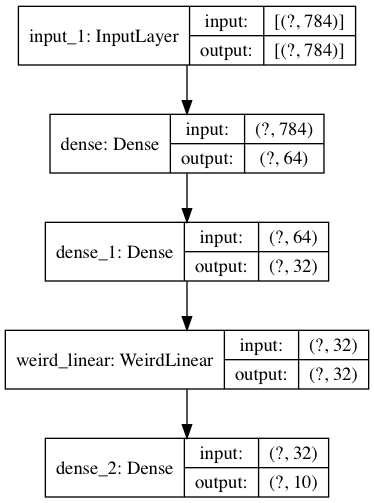

In [5]:
# this will produce a digram of the model -- requires pydot and graphviz installed (pip install pydot graphviz)
# may need to update graphviz package first (Mac: brew install graphviz/Linux: sudo apt-get install graphviz)
keras.utils.plot_model(model, to_file='model_3.png', show_shapes=True, show_layer_names=True)

In [6]:
## Built-in Loss
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print(loss, 'Loss is', loss.numpy())  # Loss: 0.09458993

loss2 = cce(
  [[1., 0., 0.], [0., 1., 0.], [1., 0., 0.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print(loss2, 'Loss is', loss2.numpy())  # Loss: 1.0725422

tf.Tensor(0.09458993, shape=(), dtype=float32) Loss is 0.09458993
tf.Tensor(1.0725422, shape=(), dtype=float32) Loss is 1.0725422


In [7]:
# Custom Loss
class WeightedCCE(keras.losses.Loss):
    def __init__(self, weights):
        super(WeightedCCE, self).__init__()
        self.weights = weights
    
    def call(self, y_true, y_pred):
        return - K.mean(K.sum(y_true * K.log(y_pred) * self.weights,axis = 1))
    
# Custom Loss Object
wcce = WeightedCCE([1, 1, 1])
loss3 = wcce(
  [[1., 0., 0.], [0., 1., 0.], [1., 0., 0.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])

print(loss3, 'Loss is', loss3.numpy())  # Loss: 0.09458993

# Custom Loss Object 2
wcce2 = WeightedCCE([10, 1, 1])
loss4 = wcce2(
  [[1., 0., 0.], [0., 1., 0.], [1., 0., 0.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])

print(loss4, 'Loss is', loss4.numpy())  # Loss: 0.09458993

tf.Tensor(1.0725422, shape=(), dtype=float32) Loss is 1.0725422
tf.Tensor(10.375821, shape=(), dtype=float32) Loss is 10.375821


In [8]:
# Custom Metric to log
def max_y_predict(y_true, y_pred):
    return K.max(y_pred)

In [9]:
############################################################
# Model compilation
# Must be called before starting training
############################################################
# For a multi-class classification problem

# Custom Loss Object 3
wcce3 = WeightedCCE([20, 20, 1, 1, 1, 2, 3, 4, 5, 6]) # Emphasize class 0 and 1


model.compile(optimizer='sgd',
              loss=wcce3, # Custom loss object 3
              metrics=['accuracy', max_y_predict])   # while sparse_categorical_crossentropy handles true labels as integers




(None, 10)


In [10]:
# Callback object 1
mcp = keras.callbacks.ModelCheckpoint(filepath="models/best_model_3.hdf5", verbose=2 , save_best_only=True)

# Custom Callback
class AccuracyLogger(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        print('Creating a log directory and cleaning files at the beginning of training')
        os.system('mkdir -p logs')
        with open('logs/train_acc.txt', 'w') as f: 
            f.write('')
        with open('logs/val_acc.txt', 'w') as f: 
            f.write('')

    def on_epoch_end(self, epoch, logs={}):
        print('Inside callback: epoch = ', epoch, 'logs = ', logs)
        train_acc = logs['accuracy']
        val_acc = logs['val_accuracy']
        with open('logs/train_acc.txt', 'a') as f: # open in append mode 'a', will clear previous data if use 'w'  
            f.write('Epoch {}: {}\n'.format(epoch, train_acc))
        with open('logs/val_acc.txt', 'a') as f: # open in append mode 'a', will clear previous data if use 'w'  
            f.write('Epoch {}: {}\n'.format(epoch, val_acc))

# Custom Callback object 2        
al = AccuracyLogger()

        
# Fitting the model with data
results = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.2 )


Train on 5600 samples, validate on 1400 samples
Epoch 1/50
(32, 10)
(32, 10)
5600/5600 [==============================] - 1s 126us/sample - loss: 7.3389 - accuracy: 0.2605 - max_y_predict: 0.8014 - val_loss: 4.6967 - val_accuracy: 0.3814 - val_max_y_predict: 0.9892
Epoch 2/50
5600/5600 [==============================] - 0s 63us/sample - loss: 3.8156 - accuracy: 0.4402 - max_y_predict: 0.9940 - val_loss: 3.2473 - val_accuracy: 0.5057 - val_max_y_predict: 0.9945
Epoch 3/50
5600/5600 [==============================] - 0s 59us/sample - loss: 2.7793 - accuracy: 0.5366 - max_y_predict: 0.9972 - val_loss: 2.5036 - val_accuracy: 0.5557 - val_max_y_predict: 0.9986
Epoch 4/50
5600/5600 [==============================] - 0s 53us/sample - loss: 2.2021 - accuracy: 0.5889 - max_y_predict: 0.9982 - val_loss: 2.1545 - val_accuracy: 0.6150 - val_max_y_predict: 0.9984
Epoch 5/50
5600/5600 [==============================] - 0s 54us/sample - loss: 1.8604 - accuracy: 0.6416 - max_y_predict: 0.9989 - val_lo

5600/5600 [==============================] - 0s 53us/sample - loss: 0.3008 - accuracy: 0.9513 - max_y_predict: 1.0000 - val_loss: 1.1646 - val_accuracy: 0.9107 - val_max_y_predict: 1.0000
Epoch 42/50
5600/5600 [==============================] - 0s 53us/sample - loss: 0.2896 - accuracy: 0.9520 - max_y_predict: 1.0000 - val_loss: 1.1576 - val_accuracy: 0.9171 - val_max_y_predict: 1.0000
Epoch 43/50
5600/5600 [==============================] - 0s 54us/sample - loss: 0.2808 - accuracy: 0.9516 - max_y_predict: 1.0000 - val_loss: 1.1398 - val_accuracy: 0.9129 - val_max_y_predict: 1.0000
Epoch 44/50
5600/5600 [==============================] - 0s 53us/sample - loss: 0.2740 - accuracy: 0.9548 - max_y_predict: 1.0000 - val_loss: 1.1679 - val_accuracy: 0.9121 - val_max_y_predict: 1.0000
Epoch 45/50
5600/5600 [==============================] - 0s 53us/sample - loss: 0.2649 - accuracy: 0.9554 - max_y_predict: 1.0000 - val_loss: 1.2205 - val_accuracy: 0.9143 - val_max_y_predict: 1.0000
Epoch 46/50


In [11]:
# You can also save the last model
model.save("models/end_model_3.hdf5")


In [14]:
y_test_pred_p = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred_p, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print(y_test_pred)
print(y_test_true)
test_acc = np.mean(y_test_pred == y_test_true)
print("Testing accuray is",test_acc)

for c in range(10):
    label_test_acc = np.mean([y_test_pred[i] == y_test_true[i] for i in range(len(y_test_pred)) if y_test_true[i] == c])
    print("Label {} Testing accuracy is".format(c), label_test_acc)


[4 0 1 ... 5 2 3]
[4 0 1 ... 5 2 3]
Testing accuray is 0.9133333333333333
Label 0 Testing accuracy is 0.9605263157894737
Label 1 Testing accuracy is 0.973293768545994
Label 2 Testing accuracy is 0.8478964401294499
Label 3 Testing accuracy is 0.8291139240506329
Label 4 Testing accuracy is 0.8442028985507246
Label 5 Testing accuracy is 0.88
Label 6 Testing accuracy is 0.9487179487179487
Label 7 Testing accuracy is 0.9483870967741935
Label 8 Testing accuracy is 0.9347079037800687
Label 9 Testing accuracy is 0.9579288025889967
